# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-03-23 08:47:54.749369


In [2]:
import pandas as pd
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv']
for filename in os.listdir():
    if 'time_series_19-covid' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [3]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    return df.T.rename(columns={0: column_name})

cases = select_russian_data(pd.read_csv('time_series_19-covid-Confirmed.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_19-covid-Deaths.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_19-covid-Recovered.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)

In [4]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

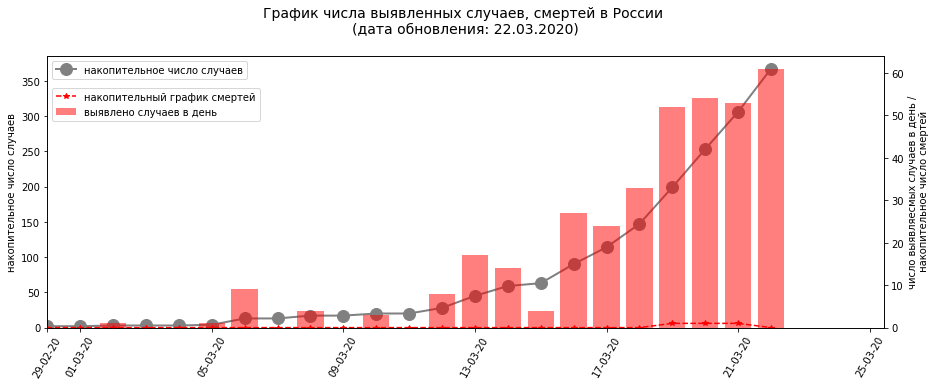

In [5]:
log = False # set True for log scale

start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases'], color='grey', marker='o', linewidth=2, markersize=12)
if log == True: ax1.set_yscale('log')
    
ax2 = ax1.twinx()
ax2.plot(russian_data['deaths'], color='red', marker='*', linestyle='--')

cases_a_day = russian_data['cases'] - russian_data['cases'].shift(1).fillna(0)
ax2.bar(x=cases_a_day.index, height=cases_a_day, color='red', alpha=0.5)

if log == True: ax2.set_yscale('log')

title = '''График числа выявленных случаев, смертей в России {}
(дата обновления: {:%d.%m.%Y})
'''.format(''.join(['(логарифмическая шкала)' if log else '']), cases_a_day.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax1.set_ylim(0)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день'], 
               loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))

ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.show()

## По регионам России

In [6]:
from io import BytesIO
import requests
import geopandas as gpd

google_sheet = 'https://docs.google.com/spreadsheets/d/1ZdNZtCBp7yp6-KwuUHB0bd-VN6VbKwRilC6ZX_jwtFE/export?gid=0&format=csv'
raw_data = requests.get(google_sheet).content
russian_regions = pd.read_csv(BytesIO(raw_data), index_col=0)
russian_regions.columns = [column.replace(' Республика', ' республика') for column in russian_regions.columns]

In [7]:
def correct_region_names(item):
    if item == 'Республика Татарстан':
        return 'Татарстан'
    elif item == 'Кабардино-Балкарская республика':
        return 'Кабардино-Балкария'
    elif item == 'Удмурсткая республика':
        return 'Удмуртия'
    elif item == 'Чувашская республика':
        return 'Чувашия'
    elif item == 'Ханты-Мансийский АО':
        return 'Ханты-Мансийский автономный округ - Югра'
    else:
        return item

data_with_id = russian_regions.T
data_with_id.index = [correct_region_names(item) for item in data_with_id.index]
data_with_id = data_with_id.rename(columns={'22-03-2020 20:33': 'corona_cases'})

In [14]:
russian_border = gpd.read_file('admin_level_2.geojson')
subjects_borders = gpd.read_file('admin_level_4.geojson')

subjects_borders = subjects_borders.merge(data_with_id, left_on='name', right_index=True)
subjects_borders['corona_cases'] = subjects_borders['corona_cases'].fillna(0)

subjects_borders = subjects_borders.to_crs('epsg:3857')
russian_border = russian_border.to_crs('epsg:3857')

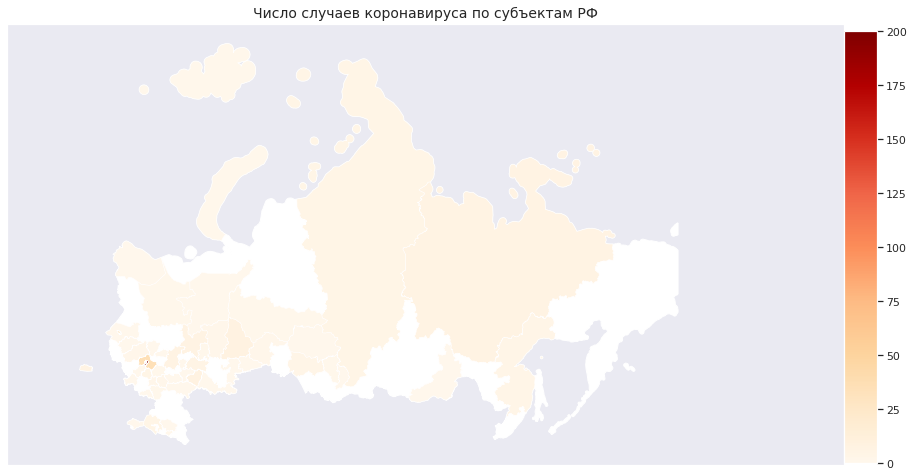

In [15]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

plt.rcParams['figure.figsize'] = (15, 15)
ax = russian_border.plot(color='white')
cmap = 'OrRd'
subjects_borders.plot(ax=ax, column='corona_cases', linewidth=0.5, cmap=cmap)
ax.set_xlim([0, ax.get_xticks().max()])
ax.set(xticklabels=[], yticklabels=[])
ax.grid(False)
plt.title('Число случаев коронавируса по субъектам РФ', fontsize=14)

fig = ax.get_figure()
vmin, vmax = 0, round(subjects_borders['corona_cases'].max(), -2)
cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()